In [29]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-57e9bcf1-29f8-8f90-2b42-d9620e0a485d)


In [30]:
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
import zipfile

In [31]:
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [32]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [33]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [34]:
import tensorflow_datasets as tfds

In [35]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

In [36]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [37]:
classes_names = ds_info.features["label"].names
classes_names, len(classes_names)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheesecake',
  'cheese_plate',
  'chicken_curry',
  'chicken_quesadilla',
  'chicken_wings',
  'chocolate_cake',
  'chocolate_mousse',
  'churros',
  'clam_chowder',
  'club_sandwich',
  'crab_cakes',
  'creme_brulee',
  'croque_madame',
  'cup_cakes',
  'deviled_eggs',
  'donuts',
  'dumplings',
  'edamame',
  'eggs_benedict',
  'escargots',
  'falafel',
  'filet_mignon',
  'fish_and_chips',
  'foie_gras',
  'french_fries',
  'french_onion_soup',
  'french_toast',
  'fried_calamari',
  'fried_rice',
  'frozen_yogurt',
  'garlic_bread',
  'gnocchi',
  'greek_salad',
  'grilled_cheese_sandwich',
  'grilled_salmon',
  'guacamole',
  'gyoza',
  'hamburger',
  'hot_and_sour_soup',
  'hot_dog',
  'huevos_rancheros',
  'hummu

In [38]:
sample = train_data.take(1)

In [39]:
sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [40]:
for image, label in sample:
  print(
      image.shape,
      image.dtype,
      label,
      classes_names[label.numpy()]
  )

(512, 512, 3) <dtype: 'uint8'> tf.Tensor(41, shape=(), dtype=int64) french_onion_soup


In [41]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[168, 148, 123],
        [192, 172, 147],
        [200, 180, 155],
        ...,
        [179, 165, 139],
        [188, 172, 147],
        [154, 138, 113]],

       [[184, 164, 139],
        [209, 189, 164],
        [212, 192, 167],
        ...,
        [207, 193, 167],
        [218, 202, 177],
        [184, 168, 143]],

       [[186, 166, 139],
        [214, 194, 167],
        [211, 194, 168],
        ...,
        [207, 193, 167],
        [217, 203, 177],
        [180, 166, 140]],

       ...,

       [[206, 198, 179],
        [236, 228, 209],
        [230, 221, 204],
        ...,
        [226, 214, 200],
        [239, 227, 211],
        [203, 191, 175]],

       [[216, 208, 187],
        [239, 231, 210],
        [233, 225, 206],
        ...,
        [227, 215, 201],
        [237, 225, 209],
        [205, 193, 177]],

       [[173, 165, 144],
        [198, 190, 169],
        [204, 196, 177],
        ...,
        [197, 185, 17

In [42]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Text(0.5, 1.0, 'french_onion_soup')

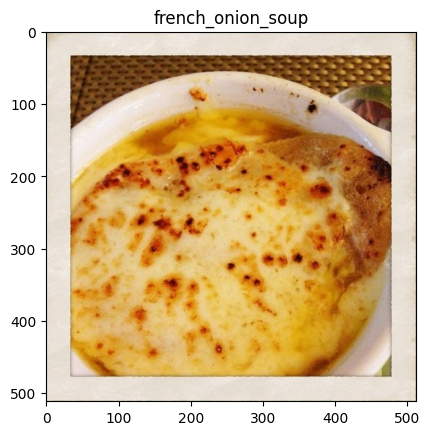

In [43]:
plt.imshow(image)
plt.title(classes_names[label.numpy()])

##preprocssing

In [44]:
def preprocssing(image, label, image_shape = 224):

    # Check if image has more than 3 dimensions (batch dimension)
  image = tf.image.resize(image, [image_shape, image_shape])  # Resize the image
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
  return tf.cast(image, dtype=tf.float32), label  # Cast to float32 and return

In [45]:
#preprocssing single image
preproccesed_img = preprocssing(image, label)[0]
print(image[:2], image.shape, image.dtype)
print(preproccesed_img[:2], preproccesed_img.shape, preproccesed_img.dtype)


tf.Tensor(
[[[168 148 123]
  [192 172 147]
  [200 180 155]
  ...
  [179 165 139]
  [188 172 147]
  [154 138 113]]

 [[184 164 139]
  [209 189 164]
  [212 192 167]
  ...
  [207 193 167]
  [218 202 177]
  [184 168 143]]], shape=(2, 512, 3), dtype=uint8) (512, 512, 3) <dtype: 'uint8'>
tf.Tensor(
[[[194.87451 173.76425 146.9096 ]
  [204.81949 183.70923 156.85458]
  [198.7273  179.70717 156.08884]
  ...
  [200.53336 185.49118 158.0971 ]
  [204.41003 188.96336 161.16478]
  [195.83179 178.49724 151.6426 ]]

 [[197.68222 176.57196 147.82945]
  [202.78714 184.50867 156.7101 ]
  [209.82327 192.36835 166.1205 ]
  ...
  [201.64575 186.60356 159.20949]
  [207.83907 192.39238 164.59381]
  [197.79169 182.345   154.54643]]], shape=(2, 224, 3), dtype=float32) (224, 224, 3) <dtype: 'float32'>


## Batch dataset

In [46]:
train_data = train_data.map(map_func=preprocssing, num_parallel_calls=tf.data.AUTOTUNE)
# shuffle data and turn it to batches, prefetch: performance optimization(load faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size = 32).prefetch(buffer_size=tf.data.AUTOTUNE)


#map preproccesing for test data
test_data = test_data.map(map_func = preprocssing, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size = 32).prefetch(buffer_size=tf.data.AUTOTUNE)



In [47]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks
* tf.keras.callbacks.TensorBoard() - allows us to keep track of our model's training history so we can inspect it later
*tf.keras.callbacks.ModelCheckpoint() - saves our model's progress after feature extraction


In [48]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "checkPoint.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True)

##mixed precision training


In [49]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [50]:
mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

<DTypePolicy "mixed_float16">

In [51]:
from tensorflow.keras import layers
# from tensorflow.keras.layers.experimental import preproccesing

input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)# have rescaling built-in
base_model.trainable = False# freeze base model layers

for layer in base_model.layers[-20:]:  # Unfreeze the last 20 layers
    layer.trainable = True

inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=False) # set model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(classes_names))(x)

outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax")(x)
model = tf.keras.Model(inputs, outputs)


model.compile(loss="sparse_categorical_crossentropy", # Use this loss fun. when labels are not one hot encoded
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [52]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pooling_layer                        │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 101)                 │         129,381 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cast_3 (Cast)                        │ (None, 101)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Activation)                 │ (None, 101)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 1,480,341 (5.65 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

In [53]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
pooling_layer True float32 <DTypePolicy "mixed_float16">
dense_1 True float32 <DTypePolicy "mixed_float16">
softmax True float32 <DTypePolicy "float32">


In [54]:
for layer in model.layers[1].layers[:30]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer_1 False float32 <DTypePolicy "mixed_float16">
rescaling_2 False float32 <DTypePolicy "mixed_float16">
normalization_1 False float32 <DTypePolicy "mixed_float16">
rescaling_3 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_fl

In [55]:
# mixed_precision.set_global_policy("float32")

## fit the model

In [56]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=4,
                                                 min_lr=1e-6)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                   patience=4,
                                                   restore_best_weights=True)

history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=20,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[early_stopping, reduce_lr, create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20241213-142326
Epoch 1/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 247s 93ms/step - accuracy: 0.4984 - loss: 2.0689 - val_accuracy: 0.7201 - val_loss: 1.0121 - learning_rate: 0.0010
Epoch 2/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2368/2368 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7201 - val_loss: 1.0067 - learning_rate: 0.0010
Epoch 3/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 197s 82ms/step - accuracy: 0.6934 - loss: 1.1419 - val_accuracy: 0.7487 - val_loss: 0.8984 - learning_rate: 0.0010
Epoch 4/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7614 - val_loss: 0.8711 - learning_rate: 0.0010
Epoch 5/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 202s 84ms/step - accuracy: 0.7468 - loss: 0.9317 - val_accuracy: 0.7704 - val_loss: 0.8463 - learning_rate: 0.0010
Epoch 6/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7529 - val_loss: 0.8922 - learning_rate: 0.0010
Epoch 7/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 205s 85ms/step - accuracy: 0.7846 - loss: 0.7737 - val_accuracy: 0.7533 - val_loss: 0.9405 - learning_rate: 0.0010
Epoch 8/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step

In [59]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 58s 74ms/step - accuracy: 0.7874 - loss: 0.8167


[0.8244979977607727, 0.7865346670150757]

In [67]:
from google.colab import drive
drive.mount('/gdrive')

#tf.keras.models.save_model(model, 'foodvision_model2.keras')


Mounted at /gdrive


In [69]:
import tensorflow as tf

# Define the encoder
encoder_inputs = tf.keras.Input(shape=(image_shape))
...
encoder_outputs = ... # Latent space representation

# Define the decoder
decoder_inputs = tf.keras.Input(shape=(latent_dim,))
label_inputs = tf.keras.Input(shape=(num_classes,)) # Label input
...
decoder_outputs = ... # Reconstructed image

# Create the VAE model
vae = tf.keras.Model([encoder_inputs, label_inputs], decoder_outputs)

# Train the VAE...

# Generate an image for a specific label
label = ... # One-hot encoded label
latent_vector = tf.random.normal(shape=(1, latent_dim))
generated_image = vae.predict([latent_vector, label])

NameError: name 'image_shape' is not defined